# Imports

In [1]:
import os
import sys
import random 
import functools

import cv2
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu
import albumentations.pytorch as albu_pt
import piq

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
%load_ext watermark
%watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

Wed Jul 29 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.0
torch 1.6.0.dev20200610
albumentations 0.4.5
photosynthesis_metrics not installed

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-111-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [4]:
!ls

configs  logs	   models     old_logs	 reports	   src	  train.py
data	 Makefile  notebooks  README.md  requirements.txt  tests  WORKPLAN.md


# Pytorch tools

In [9]:
d = {"accuracy": 1, "dice": 2}
# [1, 2] + [3, 4, 5]  + d.values()
for name, metric_meter in d.items():
    print(name, metric_meter)

accuracy 1
dice 2


# DISTS

In [74]:
"""
Implementation of Content loss, Style loss and LPIPS metric
References:
    .. [1] Gatys, Leon and Ecker, Alexander and Bethge, Matthias
    (2016). A Neural Algorithm of Artistic Style}
    Association for Research in Vision and Ophthalmology (ARVO)
    https://arxiv.org/abs/1508.06576

    .. [2] Zhang, Richard and Isola, Phillip and Efros, et al.
    (2018) The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
    2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition
    https://arxiv.org/abs/1801.03924
"""
from typing import List, Union, Callable, Tuple

import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torchvision.models import vgg16, vgg19

from piq.utils.common import _validate_input, _adjust_dimensions
from piq.utils.functional import similarity_map
from piq.utils.layers import L2Pool2d


# Map VGG names to corresponding number in torchvision layer
VGG16_LAYERS = {
    "conv1_1": '0', "relu1_1": '1',
    "conv1_2": '2', "relu1_2": '3',
    "pool1": '4',
    "conv2_1": '5', "relu2_1": '6',
    "conv2_2": '7', "relu2_2": '8',
    "pool2": '9',
    "conv3_1": '10', "relu3_1": '11',
    "conv3_2": '12', "relu3_2": '13',
    "conv3_3": '14', "relu3_3": '15',
    "pool3": '16',
    "conv4_1": '17', "relu4_1": '18',
    "conv4_2": '19', "relu4_2": '20',
    "conv4_3": '21', "relu4_3": '22',
    "pool4": '23',
    "conv5_1": '24', "relu5_1": '25',
    "conv5_2": '26', "relu5_2": '27',
    "conv5_3": '28', "relu5_3": '29',
    "pool5": '30',
}

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Constant used in feature normalization to avoid zero division
EPS = 1e-10


class ContentLoss(_Loss):
    r"""Creates Content loss that can be used for image style transfer of as a measure in
    image to image tasks.
    Uses pretrained VGG models from torchvision. Normalizes features before summation.
    Expects input to be in range [0, 1] or normalized with ImageNet statistics into range [-1, 1]

    Args:
        feature_extractor: Model to extract features or model name in {`vgg16`, `vgg19`}.
        layers: List of strings with layer names. Default: [`relu3_3`]
        weights: List of float weight to balance different layers
        replace_pooling: Flag to replace MaxPooling layer with AveragePooling. See [1] for details.
        distance: Method to compute distance between features. One of {`mse`, `mae`}.
        reduction: Reduction over samples in batch: "mean"|"sum"|"none"
        mean: List of float values used for data standartization. Default: ImageNet mean.
            If there is no need to normalize data, use [0., 0., 0.].
        std: List of float values used for data standartization. Default: ImageNet std.
            If there is no need to normalize data, use [1., 1., 1.].
        normalize_features: If true, unit-normalize each feature in channel dimension before scaling
            and computing distance. See [2] for details.

    References:
        .. [1] Gatys, Leon and Ecker, Alexander and Bethge, Matthias
        (2016). A Neural Algorithm of Artistic Style}
        Association for Research in Vision and Ophthalmology (ARVO)
        https://arxiv.org/abs/1508.06576

        .. [2] Zhang, Richard and Isola, Phillip and Efros, et al.
        (2018) The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
        2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition
        https://arxiv.org/abs/1801.03924
    """

    def __init__(self, feature_extractor: Union[str, Callable] = "vgg16", layers: Tuple[str] = ("relu3_3", ),
                 weights: List[Union[float, torch.Tensor]] = [1.], replace_pooling: bool = False,
                 distance: str = "mse", reduction: str = "mean", mean: List[float] = IMAGENET_MEAN,
                 std: List[float] = IMAGENET_STD, normalize_features: bool = False) -> None:

        super().__init__()

        if callable(feature_extractor):
            self.model = feature_extractor
            self.layers = layers
        else:
            if feature_extractor == "vgg16":
                self.model = vgg16(pretrained=True, progress=False).features
                self.layers = [VGG16_LAYERS[l] for l in layers]
            elif feature_extractor == "vgg19":
                self.model = vgg19(pretrained=True, progress=False).features
                self.layers = [VGG19_LAYERS[l] for l in layers]
            else:
                raise ValueError("Unknown feature extractor")

        if replace_pooling:
            self.model = self.replace_pooling(self.model)

        # Disable gradients
        for param in self.model.parameters():
            param.requires_grad_(False)

        self.distance = {
            "mse": nn.MSELoss,
            "mae": nn.L1Loss,
        }[distance](reduction='none')

        self.weights = [torch.tensor(w) for w in weights]
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        self.mean = mean.view(1, -1, 1, 1)
        self.std = std.view(1, -1, 1, 1)
        
        self.normalize_features = normalize_features
        self.reduction = reduction

    def forward(self, prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        r"""Computation of Content loss between feature representations of prediction and target tensors.

        Args:
            prediction: Tensor of prediction of the network.
            target: Reference tensor.

        """
        _validate_input(input_tensors=(prediction, target), allow_5d=False)
        prediction, target = _adjust_dimensions(input_tensors=(prediction, target))

        self.model.to(prediction)
        prediction_features = self.get_features(prediction)
        target_features = self.get_features(target)

        distances = self.compute_distance(prediction_features, target_features)

        # Scale distances, then average in spatial dimensions, then stack and sum in channels dimension
        loss = torch.cat([(d * w.to(d)).mean(dim=[2, 3]) for d, w in zip(distances, self.weights)], dim=1).sum(dim=1)

        if self.reduction == 'none':
            return loss

        return {'mean': loss.mean,
                'sum': loss.sum
                }[self.reduction](dim=0)

    def compute_distance(self, prediction_features: torch.Tensor, target_features: torch.Tensor) -> torch.Tensor:
        r"""Take L2 or L1 distance between feature maps"""
        return [self.distance(x, y) for x, y in zip(prediction_features, target_features)]

    def get_features(self, x: torch.Tensor) -> List[torch.Tensor]:
        r"""
        Args:
            x: torch.Tensor with shape (N, C, H, W)
        
        Returns:
            features: List of features extracted from intermediate layers
        """
        # Normalize input
        x = (x - self.mean.to(x)) / self.std.to(x)

        features = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.layers:
                features.append(self.normalize(x) if self.normalize_features else x)
        return features

    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        r"""Normalize feature maps in channel direction to unit length.
        Args:
            x: Tensor with shape (N, C, H, W)
        Returns:
            x_norm: Normalized input
        """
        norm_factor = torch.sqrt(torch.sum(x ** 2, dim=1, keepdim=True))
        return x / (norm_factor + EPS)

    def replace_pooling(self, module: torch.nn.Module) -> torch.nn.Module:
        r"""Turn All MaxPool layers into AveragePool"""
        module_output = module
        if isinstance(module, torch.nn.MaxPool2d):
            module_output = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
            
        for name, child in module.named_children():
            module_output.add_module(name, self.replace_pooling(child))
        return module_output


class DISTS(ContentLoss):
    r"""Deep Image Structure and Texture Similarity metric.
    Expects input to be in range [0, 1] or normalized with ImageNet statistics into range [-1, 1]

    Args:
        layers: List of strings with layer names. Default: [`relu3_3`]
        reduction: Reduction over samples in batch: "mean"|"sum"|"none"
        mean: List of float values used for data standartization. Default: ImageNet mean.
            If there is no need to normalize data, use [0., 0., 0.].
        std: List of float values used for data standartization. Default: ImageNet std.
            If there is no need to normalize data, use [1., 1., 1.].

    References:
        .. [1] Keyan Ding, Kede Ma, Shiqi Wang, Eero P. Simoncelli
        (2020). Image Quality Assessment: Unifying Structure and Texture Similarity.
        https://arxiv.org/abs/2004.07728
        .. [2] https://github.com/dingkeyan93/DISTS
    """
    _weights_url = "https://github.com/photosynthesis-team/piq/releases/download/v0.4.1/dists_weights.pt"

    def __init__(self, reduction: str = "mean", mean: List[float] = IMAGENET_MEAN,
                 std: List[float] = IMAGENET_STD) -> None:
        dists_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
        channels = [3, 64, 128, 256, 512, 512]

        weights = torch.hub.load_state_dict_from_url(self._weights_url, progress=False)
        dists_weights = list(torch.split(weights['alpha'], channels, dim=1))
        dists_weights.extend(torch.split(weights['beta'], channels, dim=1))

        super().__init__("vgg16", layers=dists_layers, weights=dists_weights,
                         replace_pooling=True, reduction=reduction,
                         mean=mean, std=std, normalize_features=False)

    def forward(self, prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        loss = super().forward(prediction, target)
        return 1 - loss

    def compute_distance(self, prediction_features: torch.Tensor, target_features: torch.Tensor) -> List[torch.Tensor]:
        r"""Compute structure similarity between feature maps"""
        structure_distance, texture_distance = [], []
        # Small constant for numerical stability
        EPS = 1e-5

        for x, y in zip(prediction_features, target_features):
            x_mean = x.mean([2, 3], keepdim=True)
            y_mean = y.mean([2, 3], keepdim=True)
            structure_distance.append(similarity_map(x_mean, y_mean, constant=EPS))

            x_var = ((x - x_mean) ** 2).mean([2, 3], keepdim=True)
            y_var = ((y - y_mean) ** 2).mean([2, 3], keepdim=True)
            xy_cov = (x * y).mean([2, 3], keepdim=True) - x_mean * y_mean
            texture_distance.append((2 * xy_cov + EPS) / (x_var + y_var + EPS))

        return structure_distance + texture_distance

    def get_features(self, x: torch.Tensor) -> List[torch.Tensor]:
        features = super().get_features(x)

        # Add input tensor as an additional feature
        features.insert(0, x)
        return features

    def replace_pooling(self, module: torch.nn.Module) -> torch.nn.Module:
        r"""Turn All MaxPool layers into L2Pool"""
        module_output = module
        if isinstance(module, torch.nn.MaxPool2d):
            module_output = L2Pool2d(kernel_size=3, stride=2, padding=1)
            
        for name, child in module.named_children():
            module_output.add_module(name, self.replace_pooling(child))
        return module_output


In [75]:
import numpy as np
import os,sys
import torch
from torchvision import models,transforms
import torch.nn as nn
import torch.nn.functional as F

class L2pooling(nn.Module):
    def __init__(self, filter_size=5, stride=2, channels=None, pad_off=0):
        super(L2pooling, self).__init__()
        self.padding = (filter_size - 2 )//2
        self.stride = stride
        self.channels = channels
        a = np.hanning(filter_size)[1:-1]
        g = torch.Tensor(a[:,None]*a[None,:])
        g = g/torch.sum(g)
        self.register_buffer('filter', g[None,None,:,:].repeat((self.channels,1,1,1)))

    def forward(self, input):
        input = input**2
        out = F.conv2d(input, self.filter, stride=self.stride, padding=self.padding, groups=input.shape[1])
        return (out+1e-12).sqrt()

class DISTS_orig(torch.nn.Module):
    def __init__(self, load_weights=True):
        super(DISTS_orig, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.stage1 = torch.nn.Sequential()
        self.stage2 = torch.nn.Sequential()
        self.stage3 = torch.nn.Sequential()
        self.stage4 = torch.nn.Sequential()
        self.stage5 = torch.nn.Sequential()
        for x in range(0,4):
            self.stage1.add_module(str(x), vgg_pretrained_features[x])
        self.stage2.add_module(str(4), L2pooling(channels=64))
        for x in range(5, 9):
            self.stage2.add_module(str(x), vgg_pretrained_features[x])
        self.stage3.add_module(str(9), L2pooling(channels=128))
        for x in range(10, 16):
            self.stage3.add_module(str(x), vgg_pretrained_features[x])
        self.stage4.add_module(str(16), L2pooling(channels=256))
        for x in range(17, 23):
            self.stage4.add_module(str(x), vgg_pretrained_features[x])
        self.stage5.add_module(str(23), L2pooling(channels=512))
        for x in range(24, 30):
            self.stage5.add_module(str(x), vgg_pretrained_features[x])
    
        for param in self.parameters():
            param.requires_grad = False

        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1))

        self.chns = [3,64,128,256,512,512]
        self.register_parameter("alpha", nn.Parameter(torch.randn(1, sum(self.chns),1,1)))
        self.register_parameter("beta", nn.Parameter(torch.randn(1, sum(self.chns),1,1)))
        self.alpha.data.normal_(0.1,0.01)
        self.beta.data.normal_(0.1,0.01)
        if load_weights:
            weights = torch.load('notebooks/dists_weights.pt')
            self.alpha.data = weights['alpha']
            self.beta.data = weights['beta']
        
    def forward_once(self, x):
        h = (x-self.mean)/self.std
        h = self.stage1(h)
        h_relu1_2 = h
        h = self.stage2(h)
        h_relu2_2 = h
        h = self.stage3(h)
        h_relu3_3 = h
        h = self.stage4(h)
        h_relu4_3 = h
        h = self.stage5(h)
        h_relu5_3 = h
        return [x,h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3]

    def forward(self, x, y, require_grad=False, batch_average=False):
        if require_grad:
            feats0 = self.forward_once(x)
            feats1 = self.forward_once(y)   
        else:
            with torch.no_grad():
                feats0 = self.forward_once(x)
                feats1 = self.forward_once(y) 
        dist1 = 0 
        dist2 = 0 
        c1 = 1e-6
        c2 = 1e-6

        w_sum = self.alpha.sum() + self.beta.sum()
        alpha = torch.split(self.alpha/w_sum, self.chns, dim=1)
        beta = torch.split(self.beta/w_sum, self.chns, dim=1)
        for k in range(len(self.chns)):
            x_mean = feats0[k].mean([2,3], keepdim=True)
            y_mean = feats1[k].mean([2,3], keepdim=True)

            S1 = (2*x_mean*y_mean+c1)/(x_mean**2+y_mean**2+c1)

            dist1 = dist1+(alpha[k]*S1).sum(1,keepdim=True)

            x_var = ((feats0[k]-x_mean)**2).mean([2,3], keepdim=True)
            y_var = ((feats1[k]-y_mean)**2).mean([2,3], keepdim=True)
            xy_cov = (feats0[k]*feats1[k]).mean([2,3],keepdim=True) - x_mean*y_mean
            S2 = (2*xy_cov+c2)/(x_var+y_var+c2)
#             print("xy_cov", xy_cov)
#             print("x_var", x_var)
#             print("y_var", y_var)
#             print("S2", S2)
            dist2 = dist2+(beta[k]*S2).sum(1,keepdim=True)


        score = 1 - (dist1+dist2).squeeze()
        if batch_average:
            return score.mean()
        else:
            return score


In [78]:
dists = DISTS(reduction='none')
# dists = DISTS_orig()

# prediction = torch.ones(2, 3, 32, 32)#.to("cuda")
# target = torch.ones(2, 3, 32,32)#.to("cuda")
# print(dists(prediction, target))

prediction = torch.zeros(2, 3, 32,32)#.to("cuda")
target = torch.zeros(2, 3, 32, 32)#.to("cuda")
print(dists(prediction, target))


tensor([1.7881e-07, 1.7881e-07])


In [ ]:
tensor([1.1921e-07, 1.1921e-07], grad_fn=<RsubBackward1>)
tensor([1.1921e-07, 1.1921e-07], grad_fn=<RsubBackward1>)

tensor(-0.3526)
tensor(0.5778)

EPS = 10e-6
tensor(-0.0196, device='cuda:0')
tensor(1.1921e-07, device='cuda:0')

EPS = 10e-12
tensor(-19586.9961, device='cuda:0')
tensor(1.1921e-07, device='cuda:0')

In [14]:

# My score
dists = DISTS_orig()
dists_my = DISTS_new()

print(dists(I01, i1_01_5), dists_my(I01, i1_01_5))

print(dists(goldhill_jpeg, goldhill), dists_my(goldhill_jpeg, goldhill))

torch.isclose()

tensor(0.2376, grad_fn=<RsubBackward1>) tensor(0.2377)
tensor(0.3447, grad_fn=<RsubBackward1>) tensor(0.3447)


In [12]:
# Read images
import cv2
from skimage.io import imread

I01 = torch.tensor(imread('data/external/I01.BMP')).permute(2, 0, 1).unsqueeze(0) / 255.0
i1_01_5 = torch.tensor(imread('data/external/i01_01_5.bmp')).permute(2, 0, 1).unsqueeze(0) / 255.0


goldhill = torch.tensor(imread('data/external/goldhill.gif')).unsqueeze(0).unsqueeze(0) / 255.0
goldhill_jpeg = torch.tensor(imread('data/external/goldhill_jpeg.gif')).unsqueeze(0).unsqueeze(0) / 255.0


print(I01.shape, goldhill.shape)

torch.Size([1, 3, 384, 512]) torch.Size([1, 1, 512, 512])


In [13]:
# Original score
dists_orig = DISTS_orig()
dists_orig(goldhill_jpeg, goldhill)


# prediction = torch.rand(3, 1, 96, 96)
# target = torch.rand(3, 1, 96, 96)

# dists_orig(prediction, target)

tensor(0.3447, grad_fn=<RsubBackward1>)

In [117]:
# Read images
import cv2
from skimage.io import imread

I01 = torch.tensor(imread('data/external/I01.BMP')).permute(2, 0, 1)
i1_01_5 = torch.tensor(imread('data/external/i01_01_5.bmp')).permute(2, 0, 1)

goldhill = torch.tensor(imread('data/external/goldhill.gif'))
goldhill_jpeg = torch.tensor(imread('data/external/goldhill_jpeg.gif'))



# print("i1_01_5 FSIM", fsim(i1_01_5, I01, data_range=255, chromatic=False))
# print("i1_01_5 FSIMc", fsim(i1_01_5, I01, data_range=255, chromatic=True))

# print("goldhill_jpeg FSIM", fsim(goldhill_jpeg, goldhill, data_range=255, chromatic=False))

# fsim = 
# ------------------
# image1 = mpimg.imread('data/external/I01.BMP')
# image2 = mpimg.imread('data/external/i01_01_5.bmp')

# Convert to tensor and create fake batch
# image1_t_cuda = torch.tensor(image1).permute(2, 0, 1).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).permute(2, 0, 1).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image3).permute(2, 0, 1).unsqueeze(0).cuda()
# print("Input image shape:", image1_t_cuda.shape)

# image1_t_cuda.requires_grad_()
# loss = fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1, chromatic=True)
# loss.backward()

# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1).cuda() / 255.

# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).cuda() / 255.

# fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1.0, chromatic=False)
# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).cuda() / 255.

# image1_t_cuda = torch.rand(3, 3, 8, 8)
# image2_t_cuda = torch.rand(3, 3, 8, 8)
# fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1.0, chromatic=True)





# VSI

In [62]:
from piq import fsim, psnr

In [114]:
# x = torch.zeros(4, 3, 128, 128)
# y = torch.zeros(4, 3, 128, 128)
x = torch.rand(4, 3, 128, 128)
y = torch.rand(4, 3, 128, 128)

# x = torch.ones(4, 3, 128, 128)
# y = torch.ones(4, 3, 128, 128)
fsim(x, y, reduction='none')

tensor([3.1123, 2.9341, 2.9150, 3.0244])

In [57]:
# Test different Log Gabor filters

size = (1024, 512)
def get_meshgrid(size: Tuple[int, int]) -> torch.Tensor:
    """
    Args:
        size: Shape of meshgrid to create
    """
    if size[0] % 2:
        # Odd
        x = torch.range(-(size[0] - 1) / 2, (size[0] - 1) / 2) / (size[0] - 1)
    else:
        # Even
        x = torch.range(- size[0] / 2, size[0] / 2 - 1) / size[0]
    
    if size[1] % 2:
        # Odd
        y = torch.range(-(size[1] - 1) / 2, (size[1] - 1) / 2) / (size[1] - 1)
    else:
        # Even
        y = torch.range(- size[1] / 2, size[1] / 2 - 1) / size[1]
    return torch.meshgrid(x, y)

# # lp = _lowpassfilter(size=(H, W), cutoff=.45, n=15)
# sigma_y = sigma/gamma
# g0 = torch.exp(-0.5 * ((x1**2 / sigma**2) + (y1**2 / sigma_y**2)))
        
        
def log_gabor_filter(size: Tuple[int, int], omega_0: float, sigma_f: float) -> torch.Tensor:
    """Constructs log Gabor filter of given shape. 
    """
    grid_x, grid_y = get_meshgrid(size)
    
    radius = torch.sqrt(grid_x ** 2 + grid_y ** 2)
    radius = ifftshift(radius)
    radius[0, 0] = 1
    
    gabor_filter = torch.exp((- torch.log(radius / omega_0) ** 2) / (2 * math.log(sigma_f) ** 2))
    return gabor_filter


def log_gabor_filter2(size: Tuple[int, int], omega_0: float = 0.021, sigma_f: float = 1.34) -> torch.Tensor:
    
    xx, yy = get_meshgrid(size)

    mask = xx.pow(2) + yy.pow(2) <= 0.25
    xx = xx * mask
    yy = yy * mask

    xx = ifftshift(xx)
    yy = ifftshift(yy)

    r = (xx.pow(2) + yy.pow(2)).sqrt()
    r[0, 0] = 1
    
    lg = torch.exp((- torch.log(r / omega_0) ** 2) / (2 * math.log(sigma_f) ** 2))

    lg[0, 0] = 0
    return lg

# lg = log_gabor_filter(size, omega_0=0.021, sigma_f=1.34)

xx, yy = get_meshgrid(size)
mask = xx.pow(2) + yy.pow(2) <= 0.25

# lg = lg # * mask

# lg2 = log_gabor_filter2(size, omega_0=0.021, sigma_f=1.34)

# torch.sum(lg - lg2)

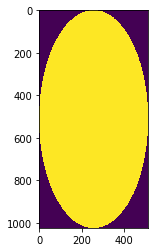

In [58]:
plt.imshow(mask)

In [30]:
print("i1_01_5 VSI", vsi(I01, i1_01_5, data_range=255))

i1_01_5 VSI tensor(0.9521)


# Download datasets

In [ ]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)
# fashin_mnist = torchvision.datasets.FashionMNIST("datasets", download=True)

In [ ]:
# !wget -P data/raw http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !wget -P data/raw http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
# !wget -P data/raw http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
# !wget -P data/raw http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget -P data/raw http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
# !wget -P data/raw http://www.ponomarenko.info/tid2013/tid2013.rar

In [1]:
# !wget -P data/raw http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip

--2020-06-25 14:49:33--  http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip
Resolving datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)... 134.34.224.175
Connecting to datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)|134.34.224.175|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip [following]
--2020-06-25 14:49:33--  https://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip
Connecting to datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)|134.34.224.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 766965996 (731M) [application/zip]
Saving to: ‘datasets/koniq10k_512x384.zip’

koniq10k_512x384.zi 100%[===================>] 731.44M  54.4MB/s    in 14s     

2020-06-25 14:49:48 (53.3 MB/s) - ‘datasets/koniq10k_512x384.zip’ saved [766965996/766965996]



In [2]:
ls

datasets/  Development.ipynb  Tests.ipynb


# Test datasets

## TID2013

In [5]:
from src.data.datasets import TID2013

transform = albu.Compose([
#     albu.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # to [-1, 1]
    albu.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.]), # to [0, 1]
    albu_pt.ToTensorV2(),
])

dataset = TID2013(transform=transform)
distorted_images, reference_images, scores = dataset[0]

In [9]:
from src.data.augmentations import get_aug
from src.data.utils import walk_files
from src.data.datasets import *
from torch.utils.data import Dataset

In [12]:
TASK = "denoise"
SIZE = 256

dataset_class = {
    "mnist": MNIST,
    "fashion_mnist": FashionMNIST, 
    "cifar10": CIFAR10,
    "cifar100": CIFAR100,
    "tinyimagenet": TinyImageNet,
    "div2k": DIV2K,
    "set5": Set5,
    "set14": Set14,
    "urba100": Urban100,
    "manga109": Manga109,
    "coil100": COIL100,
    "bsds100": BSDS100,
    "medicaldecathlon": MedicalDecathlon
}


dataset_names = [
    "div2k",
#     "bsds100",
#     "set5"
]

datasets = []
for dataset_name in dataset_names:
    transform = get_aug(aug_type="medium", task=TASK, dataset=dataset_name, size=SIZE)
    datasets.append(dataset_class[dataset_name](train=True, transform=transform))
    

Input torch.Size([3, 256, 256]) tensor(0.) tensor(1.) tensor(0.3851)
Target torch.Size([3, 256, 256]) tensor(0.) tensor(1.) tensor(0.3890)


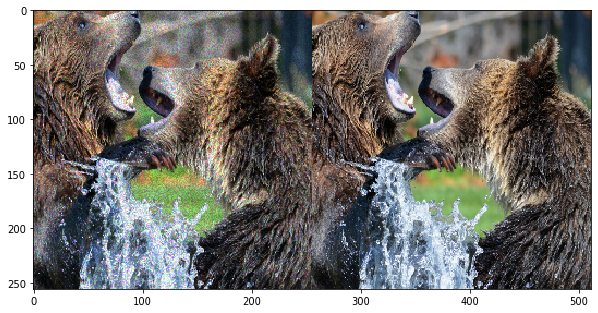

In [18]:
for dataset in datasets:
    print(dataset)
    input, target = dataset[1]
    print("Input", input.shape, input.min(), input.max(), input.mean())
    print("Target", target.shape, target.min(), target.max(), target.mean())
    plt.figure(figsize=(10, 15))
    plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))
    plt.show()
    

In [ ]:
# total_mean, total_var = [], []
# for i in range(len(div2k)):
#     image = div2k[i][1]
#     total_mean.append(image.mean(dim=[1,2]))
#     total_var.append(image.var(dim=[1,2]))
# print(torch.stack(total_mean).mean(dim=0))
# print(torch.stack(total_var).mean(dim=0))



In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="denoise", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="deblur", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
print(image.min(), image.max(), image.mean())

In [ ]:
# idx = 356
print(image[..., 0].min(), image[..., 0].max(), image[...,0].mean())
# plt.hist()
# print(image.min(), image.max(), image.mean())
# grey_image = image[..., 0]
augmented = AUG(image=image, mask=image)
input, target = augmented["image"], augmented["mask"]

## Get gaussian
# random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
# gauss = random_state.normal(0, 0.1, input.shape)
# input = input + gauss
# gauss

# print("Input", input.shape, input.min(), input.max())
# print("Target", target.shape, target.min(), target.max())

# augmented = NORM_TO_TENSOR(image=input, mask=target)
# input, target = augmented["image"], augmented["mask"]

print("Input", input.shape, input.min(), input.max())
print("Target", target.shape, target.min(), target.max())
plt.figure(figsize=(10, 10))
plt.imshow(torch.cat([input[0], target[0]], dim=1)) #.permute(1, 2, 0))
# plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))

torch.sum(input - target)

In [ ]:
torch.mean(input - target)

In [ ]:
plt.imshow((medicaldecathlon[idx][0][..., 0]))

In [ ]:
a = np.random.rand(256, 256)
a = a[:,:,np.newaxis].repeat(3, axis=2)
# a.repeat(3, axis=0).shape

In [ ]:
plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0)[:, :, [2, 1, 0]])

## Test dataloaders

In [ ]:
from src.datasets import get_dataloader

In [ ]:
datasets = ["div2k", "bsds100", "set5"]
transform = get_aug(aug_type="val", task="deblur", size=128)

for dataset in datasets:
#     train_loader = get_dataloader(dataset, transform, train=True, batch_size=64)
    
#     for batch in train_loader:
#         input, output = batch
#         print(input.shape, output.shape)
        
    
    val_loader = get_dataloader(dataset, transform, train=False)
    for batch in val_loader:
        input, output = batch
        print(input.shape, output.shape)
    
    
    for batch in train_loader:
        break

In [ ]:
dataset = BSDS100("datasets/BSDS100", train=True, transform=transform)
dataset[0][0].size()

In [ ]:
import photosynthesis_metrics as pm
image_metrics = ["kid", {}, "ssim", {}, ]

METRIC_FROM_NAME = {
    "ssim" : pm.SSIMLoss,
    "ms-ssim" : pm.MultiScaleSSIMLoss,
    "msid" : pm.MSID,
    "fid" : pm.FID,
    "kid" : pm.KID,
#     "content" : ContentLoss,
#     "style" : StyleLoss,
    "tv" : pm.TVLoss,
}


# for metric in image_metrics:
image_metrics = [METRIC_FROM_NAME[metric](**kwargs) for metric, kwargs in zip(image_metrics[::2], image_metrics[1::2])]
# list(zip(image_metrics[::2], image_metrics[1::2]))
image_metrics

In [ ]:
from collections import OrderedDict
output = OrderedDict({
    'loss': 1,
#     'mse': mse,
#     'psnr': psnr,
#     'ssim': ssim_score,
#     # 'val_ms_ssim': ms_ssim_score,
#     'input_features': input_features,
#     'target_features': target_features
})
output["test"] = 3
output["foo"] = "bar"

In [ ]:
images = torch.rand((512, 2, 32, 32))
target = torch.rand((512, 2, 64, 64))
print(f"Before interpolation: images {images.shape}")
images = F.interpolate(images, size=target.shape[-2:], mode="bilinear")
print(f"After interpolation: images {images.shape}")

In [ ]:
# from functools import b
# 
iter()

In [ ]:
a = ["foo", "bar"]
if "foo" in a:
    print(a.index("foo"))
# a.append("loss")
# print(a)
# a.pop()
# a
# for i in "etc", a:
#     print(i)

In [ ]:
features = make_layers(
    [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"], 
    batch_norm=True
)
vgg_16 = VGG(features)

In [ ]:
vgg_16

In [ ]:
x = torch.rand(10, 3, 224, 224)
layers = None
if layers is None:
    layers = ["0", "5", "10", "19", "28"]

features = []
for name, module in vgg_16.features._modules.items():
    x = module(x)
    if name in layers:
        features.append(x)


In [ ]:
features

In [ ]:
# from albumentations import ImageOnlyTransform
albu.ImageCompression()

In [ ]:
target.permute(2, 0, 1).shape, input.shape

In [ ]:
plt.imshow(target.permute(2, 0, 1).transpose(0, 2).transpose(0, 1))

In [ ]:
dataset = TinyImageNetDataset(train=True, transform=None, target_transform=None)
input, target = dataset[6]
# input.shape
# plt.imshow(input / 255.)
(input / 255.).min(), (input / 255.).max()

In [ ]:
input.transpose(0, 2).transpose(0, 1).shape

In [ ]:
# dataset[0][0].shape

In [ ]:
# from src.augmentations import get_aug
# from src.datasets import MNIST, CIFAR10, CIFAR100
from ..src.datasets
# from src.datasets import get_dataloader

In [ ]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [ ]:
transform, target_transform

In [ ]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

In [ ]:
mock = torch.rand((3, 3, 32, 32))

In [ ]:
result = model(mock)

In [ ]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

In [ ]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

In [ ]:
input.shape, target.shape

In [ ]:
import h5py

In [ ]:
datapath = "datasets/decathlon/colon.h5"
with h5py.File(datapath, "r") as f:
    for key in f.keys():
        print(key)
#     data_val = f['imgs_validation'][::10]
#     data_test = f['imgs_testing'][::10]
#     data = np.concatenate((data_val, data_test))
#     print(data.shape)
#     print(len(data))
    

# hf = 
# data_numpy = np.zeros(hf['imgs_train'].shape, dtype=numpy_type)
# # hf['dataset_name'].read_direct(n1)
# # hf.close()

In [ ]:
data = hf['imgs_train'][5000]
mask = hf['msks_train'][5000]
plt.figure(figsize=(10, 10))
plt.imshow(data.squeeze(), cmap='gray')
# plt.imshow(mask.squeeze(), alpha=0.1)
# data.max()


In [ ]:
# data.max()


In [ ]:
import torch
from torchvision import transforms
from torchvision.models import inception_v3                                                                                                                 
from torchvision.datasets import CIFAR10

import photosynthesis_metrics as pm    
from photosynthesis_metrics import IS
from tqdm.notebook import tqdm

In [ ]:
# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10 = CIFAR10(root="/home/zakirov/repoz/metrics-comparison/datasets", train=True, transform=aug)
cifar10
loader = torch.utils.data.DataLoader(cifar10, batch_size=100, num_workers=10)

In [ ]:
# model = pm.feature_extractors.fid_inception.InceptionV3(
#     resize_input=True, 
#     normalize_input=True,
#     requires_grad=False,
#     use_fid_inception=False,
# )
model = inception_v3(pretrained=True, transform_input=False).cuda()
model.eval()

## Geometry score

In [ ]:
import photosynthesis_metrics as pm
import torch

In [ ]:
gs = pm.GS(num_iters=20)
f1 = torch.rand(1000, 20)
f2 = torch.rand(1000, 20)

In [ ]:
from scipy.spatial.distance import cdist

# Read 2 images used in acticle and compute score for them

In [ ]:
transform = get_aug(aug_type='light', task='deblur', size=64)

loader = get_dataloader(
    datasets=['tinyimagenet'],
    train=True,
    transform=transform,
    batch_size=4
)

for batch in loader:
    break
    
lr = batch[0][1]
hr = batch[1][1]
print(lr.min(), lr.max())
plt.imshow((lr.permute(1,2,0) + 1) * 0.5)

In [121]:
def fsim(x: torch.Tensor, y: torch.Tensor, reduction: str = 'mean',
         data_range: Union[int, float] = 1.0, chromatic: bool = True,
         scales: int = 4, orientations: int = 4, min_length: int = 6,
         mult: int = 2, sigma_f: float = 0.55, delta_theta: float = 1.2,
         k: float = 2.0) -> torch.Tensor:
    r"""Compute Feature Similarity Index Measure for a batch of images.
    

    Args:
        x: Batch of predicted images with shape (batch_size x channels x H x W)
        y: Batch of target images with shape  (batch_size x channels x H x W)
        data_range: Value range of input images (usually 1.0 or 255). Default: 1.0
        chromatic: Flag to compute FSIMc, which also takes into account chromatic components
        scales: Number of wavelets used for computation of phase congruensy maps
        orientations: Number of filter orientations used for computation of phase congruensy maps
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian describing the log Gabor filter's
            transfer function in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations and the standard deviation
            of the angular Gaussian function used to construct filters in the frequency plane.
        k: No of standard deviations of the noise energy beyond the mean at which we set the noise
            threshold  point, below which phase congruency values get penalized.
        
    Returns:
        FSIM: Index of similarity betwen two images. Usually in [0, 1] interval.
            Can be bigger than 1 for predicted images with higher contrast than original one.
    Note:
        This implementation is based on original authors MATLAB code.
        https://www4.comp.polyu.edu.hk/~cslzhang/IQA/FSIM/FSIM.htm
        
    """
    
    _validate_input(input_tensors=(x, y), allow_5d=False)
    x, y = _adjust_dimensions(input_tensors=(x, y))
    
    # Scale to [0., 1.] range
    x = x / float(data_range)
    y = y / float(data_range)
    
    # Rescale to [0, 255] range, because all constant are calculated for this factor
    x = x * 255
    y = y * 255
    
    # Apply average pooling
    kernel_size = max(1, round(min(x.shape[-2:]) / 256))
    x = torch.nn.functional.avg_pool2d(x, kernel_size, stride=2)
    y = torch.nn.functional.avg_pool2d(y, kernel_size, stride=2)
        
    num_channels = x.size(1)

    # Convert RGB to YIQ color space https://en.wikipedia.org/wiki/YIQ
    if num_channels == 3:
        yiq_weights = torch.tensor([
            [0.299, 0.587, 0.114],
            [0.5959, -0.2746, -0.3213],
            [0.2115, -0.5227, 0.3112]]).t().to(x)
        x = torch.matmul(x.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        y = torch.matmul(y.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        
        x_lum = x[:, : 1, :, :]
        y_lum = y[:, : 1, :, :]
        
        x_i = x[:, 1, :, :]
        y_i = y[:, 1, :, :]
        x_q = x[:, 2, :, :]
        y_q = y[:, 2, :, :]

    else:
        x_lum = x
        y_lum = y

    # Compute phase congruency maps
    pc_x = _phase_congruency(
        x_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    pc_y = _phase_congruency(
        y_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    
    # Gradient maps
    kernels = torch.stack([scharr_filter(), scharr_filter().transpose(-1, -2)])
    grad_map_x = gradient_map(x_lum, kernels)
    grad_map_y = gradient_map(y_lum, kernels)
    
    # Constants from paper
    T1, T2, T3, T4, lmbda = 0.85, 160, 200, 200, 0.03
    
    # Compute FSIM
    PC = similarity_map(pc_x, pc_y, T1)
    GM = similarity_map(grad_map_x, grad_map_y, T2)
    pc_max = torch.where(pc_x > pc_y, pc_x, pc_y)
    score = GM * PC * pc_max
    
    if chromatic:
        S_I = similarity_map(x_i, y_i, T3)
        S_Q = similarity_map(x_q, y_q, T4)
        score = score * torch.abs(S_I * S_Q) ** lmbda
        # Complex gradients will work in PyTorch 1.6.0
        # score = score * torch.real((S_I * S_Q).to(torch.complex64) ** lmbda)

    result = score.sum(dim=[1, 2, 3]) / pc_max.sum(dim=[1, 2])
    
    if reduction == 'none':
        return result

    return {'mean': result.mean,
            'sum': result.sum
            }[reduction](dim=0)

In [ ]:
def _phase_congruency(x: torch.Tensor, scales: int = 4, orientations: int = 4,
                      min_length: int = 6, mult: int = 2, sigma_f: float = 0.55,
                      delta_theta: float = 1.2, k: float = 2.0) -> torch.Tensor:
    r"""Compute Phase Congruence for a batch of greyscale images

    Args:
        x: Tensor with shape Bx1xHxW
        levels: Number of wavelet scales
        orientations: Number of filter orientations
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian
            describing the log Gabor filter's transfer function
            in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations
            and the standard deviation of the angular Gaussian function
            used to construct filters in the freq. plane.
        k: No of standard deviations of the noise energy beyond the mean
            at which we set the noise threshold point, below which phase
            congruency values get penalized.
    Returns:
        PCmap: Tensor with shape BxHxW

    """
    EPS = 1e-4

    B, _, H, W = x.shape

    # Fourier transform
    imagefft = torch.rfft(x, 2, onesided=False)

    filters = _construct_filters(x, scales, orientations, min_length, mult, sigma_f, delta_theta, k)

    # Note rescaling to match power record ifft2 of filter
    filters_ifft = torch.ifft(torch.stack([filters, torch.zeros_like(filters)], dim=-1), 2)[..., 0] * math.sqrt(H * W)
    
    # Convolve image with even and odd filters
    E0 = torch.ifft(imagefft * filters.unsqueeze(-1), 2).view(B, orientations, scales, H, W, 2)

    # Amplitude of even & odd filter response. An = sqrt(real^2 + imag^2)
    an = torch.sqrt(torch.sum(E0 ** 2, dim=-1))

    # Take filter at scale 0 and sum spatially
    # Record mean squared filter value at smallest scale.
    # This is used for noise estimation.
    em_n = (filters.view(1, orientations, scales, H, W)[:, :, :1, ...] ** 2).sum(dim=[-2, -1], keepdims=True)

    # Sum of even filter convolution results.
    sum_e = E0[..., 0].sum(dim=2, keepdims=True)
    
    # Sum of odd filter convolution results.
    sum_o = E0[..., 1].sum(dim=2, keepdims=True)
    
    # Get weighted mean filter response vector, this gives the weighted mean phase angle.
    x_energy = torch.sqrt(sum_e ** 2 + sum_o ** 2) + EPS

    mean_e = sum_e / x_energy
    mean_o = sum_o / x_energy

    # Now calculate An(cos(phase_deviation) - | sin(phase_deviation)) | by
    # using dot and cross products between the weighted mean filter response
    # vector and the individual filter response vectors at each scale.
    # This quantity is phase congruency multiplied by An, which we call energy.

    # Extract even and odd convolution results.
    E = E0[..., 0]
    O = E0[..., 1]

    energy = (E * mean_e + O * mean_o - torch.abs(E * mean_o - O * mean_e)).sum(dim=2, keepdim=True)
    
    # Compensate for noise
    # We estimate the noise power from the energy squared response at the
    # smallest scale.  If the noise is Gaussian the energy squared will have a
    # Chi-squared 2DOF pdf.  We calculate the median energy squared response
    # as this is a robust statistic.  From this we estimate the mean.
    # The estimate of noise power is obtained by dividing the mean squared
    # energy value by the mean squared filter value
    
    abs_e0 = torch.sqrt(torch.sum(E0[:, :, :1, ...] ** 2, dim=-1)).reshape(B, orientations, 1, 1, H * W)
    median_e2n = torch.median(abs_e0 ** 2, dim=-1, keepdims=True).values

    mean_e2n = - median_e2n / math.log(0.5)

    # Estimate of noise power.
    noisePower = mean_e2n / em_n
    
    # Now estimate the total energy^2 due to noise
    # Estimate for sum(An^2) + sum(Ai.*Aj.*(cphi.*cphj + sphi.*sphj))
    filters_ifft = filters_ifft.view(1, orientations, scales, H, W)
    
    sum_an2 = torch.sum(filters_ifft ** 2, dim=-3, keepdim=True)
    
    sum_ai_aj = torch.zeros(B, orientations, 1, H, W).to(x)
    for s in range(scales - 1):
        sum_ai_aj = sum_ai_aj + (filters_ifft[:, :, s: s + 1] * filters_ifft[:, :, s + 1:]).sum(dim=-3, keepdim=True)
            
    sum_an2 = torch.sum(sum_an2, dim=[-1, -2], keepdim=True)
    sum_ai_aj = torch.sum(sum_ai_aj, dim=[-1, -2], keepdim=True)

    noise_energy2 = 2 * noisePower * sum_an2 + 4 * noisePower * sum_ai_aj

    # Rayleigh parameter
    tau = torch.sqrt(noise_energy2 / 2)

    # Expected value of noise energy
    noise_energy = tau * math.sqrt(math.pi / 2)
    moise_energy_sigma = torch.sqrt((2 - math.pi / 2) * tau ** 2)

    # Noise threshold
    T = noise_energy + k * moise_energy_sigma

    # The estimated noise effect calculated above is only valid for the PC_1 measure.
    # The PC_2 measure does not lend itself readily to the same analysis.  However
    # empirically it seems that the noise effect is overestimated roughly by a factor
    # of 1.7 for the filter parameters used here.

    # Empirical rescaling of the estimated noise effect to suit the PC_2 phase congruency measure
    T = T / 1.7

    # Apply noise threshold
    energy = torch.max(energy - T, torch.zeros_like(T))

    energy_all = energy.sum(dim=[1, 2])
    
    sum_an = an.sum(dim=2, keepdims=True)
    an_all = sum_an.sum(dim=[1, 2])
    # an_all = an.sum(dim=[1, 2])
    
    result_pc = energy_all / an_all
    return result_pc